In [24]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [11]:
#dataset

data = pd.read_csv('dataset/modern_RAPTOR_by_player.csv')

#choose season, for now latest season
data = data[data.season == 2022]
data.dropna(inplace=True)

In [6]:
#clustering features
features = ['raptor_box_offense', 'raptor_box_defense', 'raptor_onoff_offense', 'raptor_onoff_defense', 'predator_offense',
            'predator_defense', "pace_impact"]


In [7]:
#pre process data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

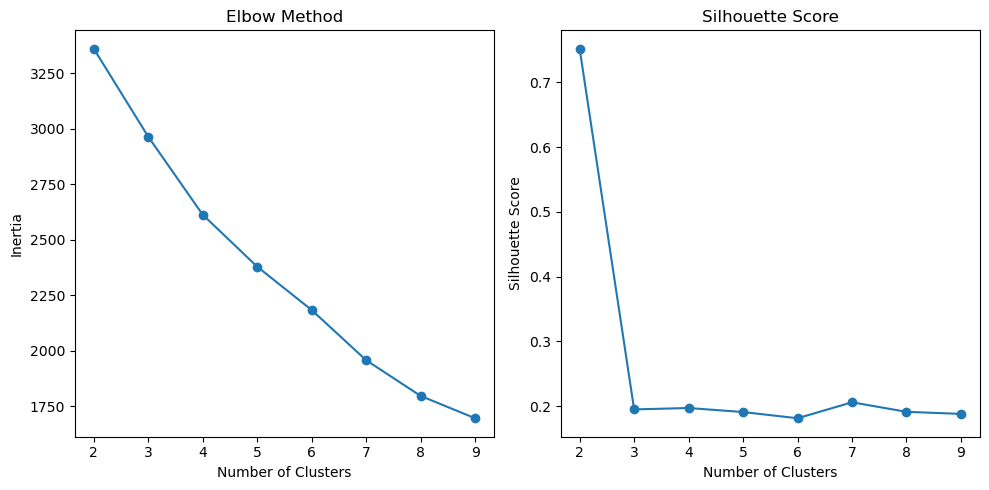

In [37]:
#define number of clusters

inertia = []
silhouette_scores = []

maxClusters = 10
minClusters = 2

# Try different numbers of clusters
for k in range(minClusters, maxClusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    if len(set(kmeans.labels_)) > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    else:
        silhouette_scores.append(None)

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(minClusters, maxClusters), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(minClusters, maxClusters), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


k = 3

In [38]:
#clustering with KMeans

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add clusters to the original dataframe
data['cluster'] = clusters

numeric_data = data.select_dtypes(include=np.number)

# Analyze clusters
cluster_stats = numeric_data.groupby('cluster').mean()



/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


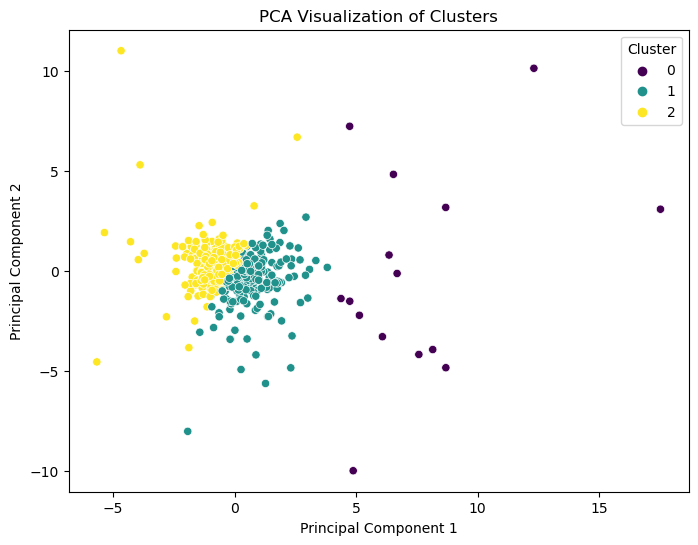

In [39]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='viridis')
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

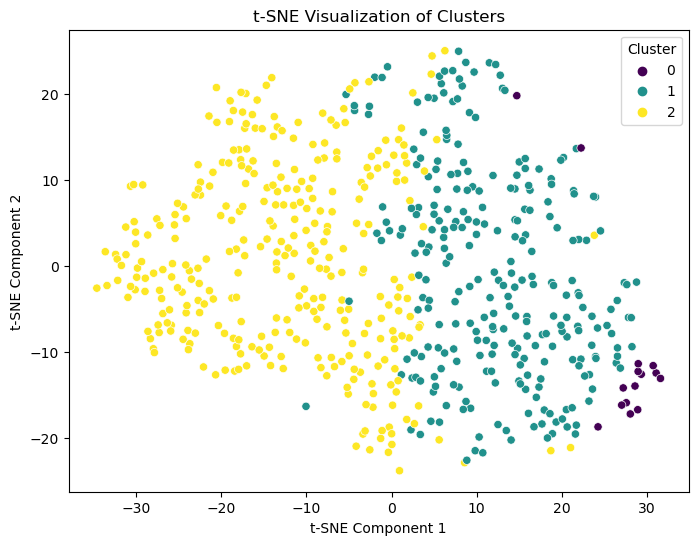

In [40]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

# Plot t-SNE visualization with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

In [41]:
# Assign NBA-related names to clusters
def assign_cluster_names(cluster_stats):
    cluster_names = []
    for idx, row in cluster_stats.iterrows():
        # Example naming criteria, adjust as needed
        if row['raptor_defense'] > row['raptor_offense']:
            cluster_names.append("Defensive Specialists")
        elif row['raptor_offense'] > row['raptor_defense']:
            cluster_names.append("Offensive Powerhouses")
        else:
            cluster_names.append("Balanced Players")
    return cluster_names

In [42]:
cluster_names = assign_cluster_names(cluster_stats)

# Add cluster names to the cluster statistics dataframe
cluster_stats['cluster_name'] = cluster_names

# Print cluster statistics along with assigned names
print(cluster_stats)


         season         poss           mp  raptor_box_offense  \
cluster                                                         
0        2022.0    20.600000     9.600000          -13.646665   
1        2022.0  1172.541045   559.809701           -3.257628   
2        2022.0  3116.312693  1502.749226            0.717153   

         raptor_box_defense  raptor_box_total  raptor_onoff_offense  \
cluster                                                               
0                -12.179485        -25.826151            -36.143147   
1                 -0.907485         -4.165113             -4.835565   
2                  0.099140          0.816293              1.189733   

         raptor_onoff_defense  raptor_onoff_total  raptor_offense  \
cluster                                                             
0                  -24.515786          -60.658932      -19.212630   
1                    0.299784           -4.535781       -3.775307   
2                    0.598277            1